## Experiment to determine Frequency for running Model 

Author : Sai Siddartha Maram


Contact: msaisiddartha1@gmail.com | smaram_be16@thapar.edu

### Objectives
1. Run detection at Camera FPS, in our case the camera FPS is 30FPS, to start of I will run detection on every 30th image.
2. Log all the bounding boxes and classes of objects detected
3. Develop a certain metric in terms of centers of bounding boxes, classes detected to determine if the two scenes are different
4. Try delta methods and see if they match


In [3]:
%load_ext Cython
import cv2
import numpy as np
import argparse
import time
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils

from scipy.spatial import distance as dist
import numpy as np

from skimage.measure import compare_ssim
from PIL import Image
import time

import scipy
import random

import tensorflow as tf
import math

# Image manipulation.
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
import inception5h
model = inception5h.Inception5h()

import imagehash

from numpy import load


from numpy import asarray
from numpy import save
# define data
# My Packages
import constants
import helper



Instructions for updating:
Use tf.gfile.GFile.



Loading Model : YOLOV3

In [4]:
options = constants.options_v3
np.random.seed(42)
LABELS = open(options['labelsPath']).read().strip().split("\n")
color = (255, 0, 0)
inception5h.maybe_download()

Data has apparently already been downloaded and unpacked.


1. Load the darknet model using readNetFromDarkent(), feel free to try other DL models
2.  In CV2.dnn you load a model and then forward propgate the image for prediction, 
    the forwad function expects you give the layer till which you want the image to be 
    propgated, in our case since we want the final result, we want the image to be 
    propgated till the last layer. The .getLayerNames() gives the list of all layers.
    From here to identify the last layer, we need to get last unconnected layer, the 
    unconnected layers can be found by .getUnconnectedOutLayers().
3. blob, the cv.dnn does not take a raw image, instead takes a blob, A blob is an image which 
   is modified and smoothed as per the network requirments. For Ex. 
   YOLO takes in an image only of the size 416 x 416 (single channel)
   hence we reduce each color from [0-255] to [0-1] and image size (416,416)

In [5]:
def predict_object(image_path,net):
    start = time.time()
    image = cv2.imread(image_path)
    #image=cv2.resize(image,(416,416))
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(
        image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerOutputs = net.forward(ln)
    

    # show timing information on YOLO
    

    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > options['confidence']:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, options['confidence'], options['threshold'])
    
    detections=[]
    if len(idxs) > 0:
        for i in idxs.flatten():
            temp_list=[]
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 3)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            

            temp_list.append(x)
            temp_list.append(y)
            temp_list.append(w)
            temp_list.append(h)
            temp_list.append(LABELS[classIDs[i]])
            temp_list.append(confidences[i])
            detections.append(temp_list)
            
    print('Time Taken', time.time()-start)   
    return image,detections

In [6]:
def predict_image(image,net):
    start = time.time()
    #image = cv2.imread(image_path)
    #image=cv2.resize(image,(416,416))
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(
        image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerOutputs = net.forward(ln)
    

    # show timing information on YOLO
    

    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > options['confidence']:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, options['confidence'], options['threshold'])
    
    detections=[]
    if len(idxs) > 0:
        for i in idxs.flatten():
            temp_list=[]
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 3)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
           

            temp_list.append(x)
            temp_list.append(y)
            temp_list.append(w)
            temp_list.append(h)
            temp_list.append(LABELS[classIDs[i]])
            temp_list.append(confidences[i])
            detections.append(temp_list)
            
    print('Time Taken', time.time()-start)   
    return image,detections

In [7]:
net = cv2.dnn.readNetFromDarknet(options['model'], options['load'])

Time Taken 0.8515560626983643
Number of Detections: 3
[123, 222, 196, 321, 'dog', 0.997923731803894]
[117, 124, 451, 308, 'bicycle', 0.9899414777755737]
[473, 86, 218, 80, 'truck', 0.9365639686584473]


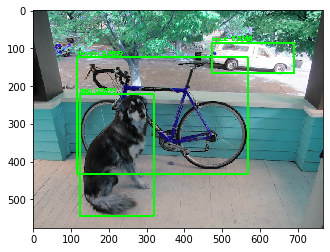

In [8]:
image,detections=predict_object('testing_images/sample_dog.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')
plt.imshow(image)

Time Taken 0.3888661861419678
Number of Detections: 7
[1168, 444, 311, 161, 'car', 0.9971790313720703]
[1238, 335, 44, 110, 'person', 0.9966909289360046]
[1664, 357, 40, 96, 'person', 0.986341655254364]
[1613, 386, 47, 116, 'person', 0.9570065140724182]
[1712, 387, 39, 88, 'person', 0.8744476437568665]
[1373, 69, 43, 80, 'person', 0.7361916303634644]
[1373, 72, 27, 50, 'person', 0.6172140836715698]


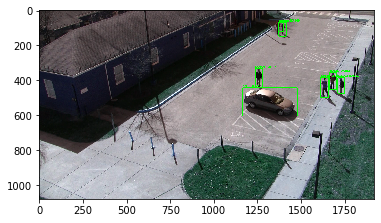

In [9]:
image,detections=predict_object('testing_images/16892.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')
plt.imshow(image)


Time Taken 0.38182783126831055
Number of Detections: 7
[1168, 444, 311, 161, 'car', 0.9971790313720703]
[1238, 335, 44, 110, 'person', 0.9966909289360046]
[1664, 357, 40, 96, 'person', 0.986341655254364]
[1613, 386, 47, 116, 'person', 0.9570065140724182]
[1712, 387, 39, 88, 'person', 0.8744476437568665]
[1373, 69, 43, 80, 'person', 0.7361916303634644]
[1373, 72, 27, 50, 'person', 0.6172140836715698]


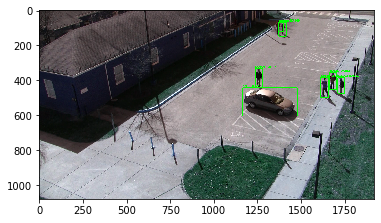

In [10]:
image,detections=predict_object('testing_images/16892.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')
plt.imshow(image)

In [11]:
def image_subtraction(path_image1,path_image2):
    img1 = cv2.imread(path_image1)
    img2 = cv2.imread(path_image2)


    start_time=time.time()
    grayA = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    (score, grad,diff) = compare_ssim(grayA, grayB, full=True,gradient=True)
    #value ranges between -1 to 1. 1 indicates a perfect match
    print('Time Taken for execution',time.time()-start_time)
    print("SSIM: {}".format(score))
    


In [12]:
image_subtraction('testing_images/4561.jpg','testing_images/16892.jpg')

Time Taken for execution 0.4679594039916992
SSIM: 0.837833208292906


In [13]:
def histogram_matching(path_image1, path_image2):
    img1 = cv2.imread(path_image1)
    img2 = cv2.imread(path_image2)
#     plt.hist(img1.ravel(),256,[0,256])
#     plt.show()
#     plt.hist(img2.ravel(),256,[0,256])
#     plt.show()

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    start_time=time.time()

    hist1 = cv2.calcHist(img1, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()

    hist2 = cv2.calcHist(img2, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.normalize(hist2, hist2).flatten()

    #a = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT) ----> WASTE!
    #a = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL) ----->Waste!
    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    print('[INFO]Time for Histogram Mapping',time.time()-start_time)

    return chi_square


In [14]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/4561.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.0032677650451660156
CHI Square value 0.0


In [15]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/16892.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.0009553432464599609
CHI Square value 0.07969235225853039


In [16]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/2.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.00093841552734375
CHI Square value 0.16284510427246612


# DREAM:Cryption

<b>Function</b> : generate_new_look_up_table_random(@param1,@param2)

<b>Param</b> : color_channel, chunk size

<b>Objective</b>:
generate_new_look_up_table_random(R,n): this takes in 1 dimension color channel and shuffles it all in chunks of 8 

In [17]:
def generate_new_look_up_table_random(R,n):
    R_new=[R[i:i + n] for i in range(0, len(R), n)]    
    res = random.sample(R_new, len(R_new)) 
    R_prime=[]
    for i in res:
        for j in i:
            R_prime.append(j)
 
    return R_prime

<b>Function</b>: lut_generator(@param)

<b>Param</b> : chunksize

<b>Objective</b>: takes in a chunk size and gives out a look up table with random shuffling for each of the color channels
    

In [18]:
def lut_generator(n):
    lut = np.zeros((256, 1, 3), dtype=np.uint8)
    lut[:, 0, 0] = generate_new_look_up_table_random([i for i in range(0,256)],n)
    lut[:, 0, 1] =lut[:, 0, 0] #generate_new_look_up_table_random([i for i in range(0,256)],n)
    lut[:, 0, 2] =lut[:, 0, 0] #generate_new_look_up_table_random([i for i in range(0,256)],n)
    return lut

<b>Function</b>: encrypt(@param1,@param2)

<b>Param</b> : image_to_encrypt,look_up_table (key)

<b>Objective</b>: Gives out an encrypted image    

In [19]:
def encrypt(image,lut):
    im_color = cv2.LUT(image,lut)
    return im_color
    

In [20]:
%%cython -a
cimport numpy


#cython.boundscheck(False)
cpdef unsigned char[:,:, :] decrypt(numpy.ndarray lut, unsigned char [:,:,:] im_encoded):
    # set the variable extension types
    cdef unsigned char [:,:,:] im_decoded=im_encoded
    cdef int i, j, w, h
    cdef list B = lut[:,0,0].tolist()
    cdef list G = lut[:,0,1].tolist()
    cdef list R = lut[:,0,2].tolist()
    
    h = im_decoded.shape[0]
    w = im_decoded.shape[1]

    for i in range(0, h):
        for j in range(0, w):
            im_decoded[i][j][0]=B.index(im_encoded[i][j][0])
            im_decoded[i][j][1]=G.index(im_encoded[i][j][1])
            im_decoded[i][j][2]=R.index(im_encoded[i][j][2])

    return im_encoded

In [25]:
image_to_encrypt=cv2.imread('testing_images/0.jpg')

cv2.imshow('image_to_enc',image_to_encrypt)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [26]:
lut = lut_generator(8)

In [31]:
encrypted_image = encrypt(image_to_encrypt, lut )
cv2.imshow('enc',encrypted_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite('encrypted.jpg',encrypted_image)

True

In [32]:
save('encrypted.npy',encrypted_image)

CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.88 s


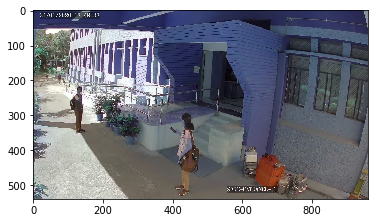

In [33]:

object_to_decrypt=load('encrypted.npy')

%time dec=decrypt(lut,object_to_decrypt)
dec = np.asarray(dec)

cv2.imshow('dec',dec)
cv2.waitKey(0)
cv2.destroyAllWindows()


cv2.imwrite('decrypted.jpg',dec)
plt.imshow(dec)

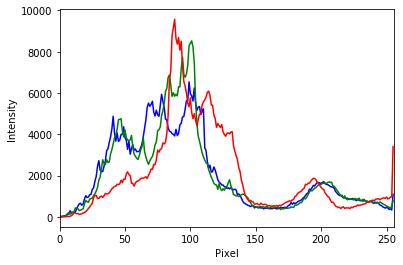

In [34]:
color = ('b','g','r')
img=cv2.imread('testing_images/0.jpg')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.ylabel('Intensity')
plt.xlabel('Pixel')
plt.show()

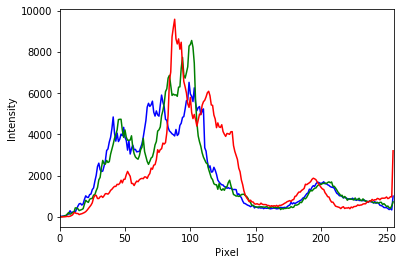

In [35]:
color = ('b','g','r')
img=cv2.imread('decrypted.jpg')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.ylabel('Intensity')
plt.xlabel('Pixel')
plt.show()

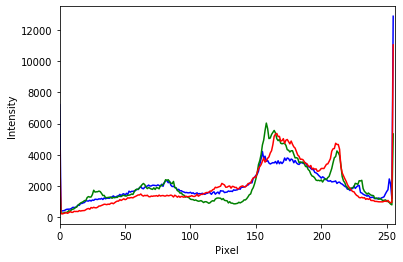

In [36]:
color = ('b','g','r')
img=cv2.imread('encrypted.jpg')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.ylabel('Intensity')
plt.xlabel('Pixel')
plt.show()

Time Taken 0.40262413024902344
Number of Detections: 7
[108, 217, 43, 134, 'person', 0.9940825700759888]
[397, 290, 74, 229, 'person', 0.9665061235427856]
[233, 295, 76, 94, 'pottedplant', 0.935905396938324]
[393, 335, 11, 9, 'cell phone', 0.606874406337738]
[173, 240, 59, 80, 'pottedplant', 0.5710673332214355]
[202, 247, 58, 102, 'pottedplant', 0.44901546835899353]
[701, 468, 31, 54, 'bottle', 0.4185127317905426]


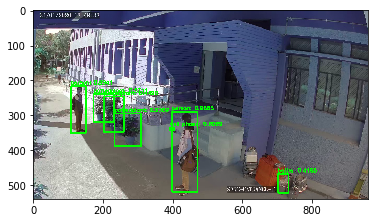

In [39]:
image,detections=predict_image(image_to_encrypt,net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')
plt.imshow(image)


Time Taken 0.38948535919189453
Number of Detections: 0



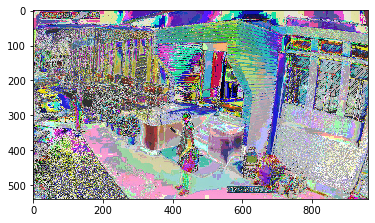

In [40]:
image,detections=predict_object('encrypted.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')
plt.imshow(image)

### Detection Performance and Evaluation Based on Image Sizes

In [41]:
def multi_shape_detection(image_path,net):
    img=cv2.imread(image_path)
    
    h,w,_=img.shape
    #half
    print(img.shape)
    img_1 = cv2.resize(img,(w//2,h//2))
    print(img_1.shape)
    #one fourth
    img_2 = cv2.resize(img_1,(w//4,h//4))
    print(img_2.shape)
    result = predict_image(img,net)
    result_2 = predict_image(img_1,net)
    result_4 = predict_image(img_2,net)
    
    return result,result_2,result_4

In [ ]:
image_path='testing_images/16892.jpg' 
result,result_2,result_4 = multi_shape_detection(image_path,net)
# print('Number of Detections in full image:', len(detections))
# print(*detections,sep='\n')

In [ ]:
print('Number of Detections in half size:', len(result[1]))
print(*result[1],sep='\n')
plt.imshow(result[0])

In [ ]:
print('Number of Detections in half size:', len(result_2[1]))
print(*result[1],sep='\n')
plt.imshow(result_2[0])

In [ ]:
print('Number of Detections in half size:', len(result_4[1]))
print(*result[1],sep='\n')
plt.imshow(result_4[0])

### Processing IISc Video Feed 

In [49]:
def break_video_to_frame(input_path):
    vidcap = cv2.VideoCapture(input_path)
    vidcap.set(cv2.CAP_PROP_FPS,12.0)

    
    success,image = vidcap.read()
    count = 0
    while success:
        path='frames/{}.jpg'.format(count)
        print(path)
        image = cv2.resize(image,(960,540))
        cv2.imwrite(path, image)     # save frame as JPEG file      
        success,image = vidcap.read()
        print('Read a new frame {}: '.format(count), success)
        count += 1

In [50]:
break_video_to_frame('iisc_sample_1.mp4')
print('DONE')

frames/0.jpg
Read a new frame 0:  True
frames/1.jpg
Read a new frame 1:  True
frames/2.jpg
Read a new frame 2:  True
frames/3.jpg
Read a new frame 3:  True
frames/4.jpg
Read a new frame 4:  True
frames/5.jpg
Read a new frame 5:  True
frames/6.jpg
Read a new frame 6:  True
frames/7.jpg
Read a new frame 7:  True
frames/8.jpg
Read a new frame 8:  True
frames/9.jpg
Read a new frame 9:  True
frames/10.jpg
Read a new frame 10:  True
frames/11.jpg
Read a new frame 11:  True
frames/12.jpg
Read a new frame 12:  True
frames/13.jpg
Read a new frame 13:  True
frames/14.jpg
Read a new frame 14:  True
frames/15.jpg
Read a new frame 15:  True
frames/16.jpg
Read a new frame 16:  True
frames/17.jpg
Read a new frame 17:  True
frames/18.jpg
Read a new frame 18:  True
frames/19.jpg
Read a new frame 19:  True
frames/20.jpg
Read a new frame 20:  True
frames/21.jpg
Read a new frame 21:  True
frames/22.jpg
Read a new frame 22:  True
frames/23.jpg
Read a new frame 23:  True
frames/24.jpg
Read a new frame 24:  

Read a new frame 202:  True
frames/203.jpg
Read a new frame 203:  True
frames/204.jpg
Read a new frame 204:  True
frames/205.jpg
Read a new frame 205:  True
frames/206.jpg
Read a new frame 206:  True
frames/207.jpg
Read a new frame 207:  True
frames/208.jpg
Read a new frame 208:  True
frames/209.jpg
Read a new frame 209:  True
frames/210.jpg
Read a new frame 210:  True
frames/211.jpg
Read a new frame 211:  True
frames/212.jpg
Read a new frame 212:  True
frames/213.jpg
Read a new frame 213:  True
frames/214.jpg
Read a new frame 214:  True
frames/215.jpg
Read a new frame 215:  True
frames/216.jpg
Read a new frame 216:  True
frames/217.jpg
Read a new frame 217:  True
frames/218.jpg
Read a new frame 218:  True
frames/219.jpg
Read a new frame 219:  True
frames/220.jpg
Read a new frame 220:  True
frames/221.jpg
Read a new frame 221:  True
frames/222.jpg
Read a new frame 222:  True
frames/223.jpg
Read a new frame 223:  True
frames/224.jpg
Read a new frame 224:  True
frames/225.jpg
Read a new 

Read a new frame 398:  True
frames/399.jpg
Read a new frame 399:  True
frames/400.jpg
Read a new frame 400:  True
frames/401.jpg
Read a new frame 401:  True
frames/402.jpg
Read a new frame 402:  True
frames/403.jpg
Read a new frame 403:  True
frames/404.jpg
Read a new frame 404:  True
frames/405.jpg
Read a new frame 405:  True
frames/406.jpg
Read a new frame 406:  True
frames/407.jpg
Read a new frame 407:  True
frames/408.jpg
Read a new frame 408:  True
frames/409.jpg
Read a new frame 409:  True
frames/410.jpg
Read a new frame 410:  True
frames/411.jpg
Read a new frame 411:  True
frames/412.jpg
Read a new frame 412:  True
frames/413.jpg
Read a new frame 413:  True
frames/414.jpg
Read a new frame 414:  True
frames/415.jpg
Read a new frame 415:  True
frames/416.jpg
Read a new frame 416:  True
frames/417.jpg
Read a new frame 417:  True
frames/418.jpg
Read a new frame 418:  True
frames/419.jpg
Read a new frame 419:  True
frames/420.jpg
Read a new frame 420:  True
frames/421.jpg
Read a new 

Read a new frame 594:  True
frames/595.jpg
Read a new frame 595:  True
frames/596.jpg
Read a new frame 596:  True
frames/597.jpg
Read a new frame 597:  True
frames/598.jpg
Read a new frame 598:  True
frames/599.jpg
Read a new frame 599:  True
frames/600.jpg
Read a new frame 600:  True
frames/601.jpg
Read a new frame 601:  True
frames/602.jpg
Read a new frame 602:  True
frames/603.jpg
Read a new frame 603:  True
frames/604.jpg
Read a new frame 604:  True
frames/605.jpg
Read a new frame 605:  True
frames/606.jpg
Read a new frame 606:  True
frames/607.jpg
Read a new frame 607:  True
frames/608.jpg
Read a new frame 608:  True
frames/609.jpg
Read a new frame 609:  True
frames/610.jpg
Read a new frame 610:  True
frames/611.jpg
Read a new frame 611:  True
frames/612.jpg
Read a new frame 612:  True
frames/613.jpg
Read a new frame 613:  True
frames/614.jpg
Read a new frame 614:  True
frames/615.jpg
Read a new frame 615:  True
frames/616.jpg
Read a new frame 616:  True
frames/617.jpg
Read a new 

Read a new frame 788:  True
frames/789.jpg
Read a new frame 789:  True
frames/790.jpg
Read a new frame 790:  True
frames/791.jpg
Read a new frame 791:  True
frames/792.jpg
Read a new frame 792:  True
frames/793.jpg
Read a new frame 793:  True
frames/794.jpg
Read a new frame 794:  True
frames/795.jpg
Read a new frame 795:  True
frames/796.jpg
Read a new frame 796:  True
frames/797.jpg
Read a new frame 797:  True
frames/798.jpg
Read a new frame 798:  True
frames/799.jpg
Read a new frame 799:  True
frames/800.jpg
Read a new frame 800:  True
frames/801.jpg
Read a new frame 801:  True
frames/802.jpg
Read a new frame 802:  True
frames/803.jpg
Read a new frame 803:  True
frames/804.jpg
Read a new frame 804:  True
frames/805.jpg
Read a new frame 805:  True
frames/806.jpg
Read a new frame 806:  True
frames/807.jpg
Read a new frame 807:  True
frames/808.jpg
Read a new frame 808:  True
frames/809.jpg
Read a new frame 809:  True
frames/810.jpg
Read a new frame 810:  True
frames/811.jpg
Read a new 

Read a new frame 984:  True
frames/985.jpg
Read a new frame 985:  True
frames/986.jpg
Read a new frame 986:  True
frames/987.jpg
Read a new frame 987:  True
frames/988.jpg
Read a new frame 988:  True
frames/989.jpg
Read a new frame 989:  True
frames/990.jpg
Read a new frame 990:  True
frames/991.jpg
Read a new frame 991:  True
frames/992.jpg
Read a new frame 992:  True
frames/993.jpg
Read a new frame 993:  True
frames/994.jpg
Read a new frame 994:  True
frames/995.jpg
Read a new frame 995:  True
frames/996.jpg
Read a new frame 996:  True
frames/997.jpg
Read a new frame 997:  True
frames/998.jpg
Read a new frame 998:  True
frames/999.jpg
Read a new frame 999:  True
frames/1000.jpg
Read a new frame 1000:  True
frames/1001.jpg
Read a new frame 1001:  True
frames/1002.jpg
Read a new frame 1002:  True
frames/1003.jpg
Read a new frame 1003:  True
frames/1004.jpg
Read a new frame 1004:  True
frames/1005.jpg
Read a new frame 1005:  True
frames/1006.jpg
Read a new frame 1006:  True
frames/1007.

In [51]:
save('key_1.npy',lut)

def encrypt_folder(input_folder,lut):

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            input_path=input_folder+'/'+filename
            print(input_path)
            image=cv2.imread(input_path)
            print(image.shape)
            encrypted_image = encrypt(image, lut)
            path='encrypted_frames_iisc_key_1/{}.npy'.format(filename[:-4])
            print(path)
            save(path,encrypted_image)
    


In [52]:
%time encrypt_folder('frames',lut)

frames/95.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/95.npy
frames/282.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/282.npy
frames/635.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/635.npy
frames/916.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/916.npy
frames/189.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/189.npy
frames/741.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/741.npy
frames/688.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/688.npy
frames/925.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/925.npy
frames/905.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/905.npy
frames/1015.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1015.npy
frames/377.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/377.npy
frames/29.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/29.npy
frames/765.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/765.npy
frames/365.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/365.npy
frames/362.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/362.npy
frames/166.jpg
(540, 960, 3

(540, 960, 3)
encrypted_frames_iisc_key_1/36.npy
frames/924.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/924.npy
frames/576.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/576.npy
frames/466.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/466.npy
frames/780.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/780.npy
frames/692.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/692.npy
frames/422.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/422.npy
frames/738.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/738.npy
frames/882.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/882.npy
frames/380.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/380.npy
frames/137.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/137.npy
frames/1045.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1045.npy
frames/1014.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1014.npy
frames/809.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/809.npy
frames/613.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/613.npy
frames/173.jpg
(540, 960, 3)
encrypte

(540, 960, 3)
encrypted_frames_iisc_key_1/940.npy
frames/508.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/508.npy
frames/832.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/832.npy
frames/546.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/546.npy
frames/742.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/742.npy
frames/88.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/88.npy
frames/897.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/897.npy
frames/351.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/351.npy
frames/1043.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1043.npy
frames/675.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/675.npy
frames/850.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/850.npy
frames/16.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/16.npy
frames/38.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/38.npy
frames/860.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/860.npy
frames/748.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/748.npy
frames/227.jpg
(540, 960, 3)
encrypted_frame

(540, 960, 3)
encrypted_frames_iisc_key_1/674.npy
frames/436.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/436.npy
frames/534.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/534.npy
frames/233.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/233.npy
frames/991.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/991.npy
frames/984.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/984.npy
frames/695.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/695.npy
frames/493.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/493.npy
frames/784.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/784.npy
frames/1079.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1079.npy
frames/705.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/705.npy
frames/687.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/687.npy
frames/634.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/634.npy
frames/1056.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1056.npy
frames/449.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/449.npy
frames/591.jpg
(540, 960, 3)
encrypt

(540, 960, 3)
encrypted_frames_iisc_key_1/131.npy
frames/857.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/857.npy
frames/109.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/109.npy
frames/600.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/600.npy
frames/998.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/998.npy
frames/61.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/61.npy
frames/23.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/23.npy
frames/872.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/872.npy
frames/790.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/790.npy
frames/877.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/877.npy
frames/209.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/209.npy
frames/608.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/608.npy
frames/208.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/208.npy
frames/583.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/583.npy
frames/272.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/272.npy
frames/93.jpg
(540, 960, 3)
encrypted_frames

(540, 960, 3)
encrypted_frames_iisc_key_1/980.npy
frames/142.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/142.npy
frames/336.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/336.npy
frames/343.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/343.npy
frames/155.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/155.npy
frames/497.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/497.npy
frames/885.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/885.npy
frames/307.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/307.npy
frames/1077.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1077.npy
frames/798.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/798.npy
frames/843.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/843.npy
frames/621.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/621.npy
frames/585.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/585.npy
frames/762.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/762.npy
frames/655.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/655.npy
frames/601.jpg
(540, 960, 3)
encrypted

(540, 960, 3)
encrypted_frames_iisc_key_1/482.npy
frames/875.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/875.npy
frames/245.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/245.npy
frames/58.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/58.npy
frames/764.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/764.npy
frames/46.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/46.npy
frames/887.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/887.npy
frames/726.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/726.npy
frames/1049.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1049.npy
frames/685.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/685.npy
frames/890.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/890.npy
frames/519.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/519.npy
frames/47.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/47.npy
frames/990.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/990.npy
frames/663.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/663.npy
frames/59.jpg
(540, 960, 3)
encrypted_frames

(540, 960, 3)
encrypted_frames_iisc_key_1/118.npy
frames/368.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/368.npy
frames/256.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/256.npy
frames/578.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/578.npy
frames/453.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/453.npy
frames/1051.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1051.npy
frames/598.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/598.npy
frames/303.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/303.npy
frames/1062.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/1062.npy
frames/786.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/786.npy
frames/491.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/491.npy
frames/744.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/744.npy
frames/391.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/391.npy
frames/565.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/565.npy
frames/240.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/240.npy
frames/329.jpg
(540, 960, 3)
encrypt

(540, 960, 3)
encrypted_frames_iisc_key_1/727.npy
frames/27.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/27.npy
frames/477.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/477.npy
frames/3.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/3.npy
frames/920.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/920.npy
frames/431.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/431.npy
frames/202.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/202.npy
frames/296.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/296.npy
frames/454.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/454.npy
frames/255.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/255.npy
frames/654.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/654.npy
frames/130.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/130.npy
frames/658.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/658.npy
frames/580.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/580.npy
frames/35.jpg
(540, 960, 3)
encrypted_frames_iisc_key_1/35.npy
frames/731.jpg
(540, 960, 3)
encrypted_frames_ii

In [55]:
def decrypt_folder(input_folder,lut):
        for filename in os.listdir(input_folder):
            if filename.endswith(".npy"):
                input_path=input_folder+'/'+filename
                print(input_path)
                image_object=load(input_path)
                dec=decrypt(lut,image_object)
                dec = np.asarray(dec)
                path='decrypted_frames_iisc_key_1/{}.jpg'.format(filename[:-4])
                print(path)
                cv2.imwrite(path,dec)

In [56]:
%time decrypt_folder('encrypted_frames_iisc_key_1',lut)

encrypted_frames_iisc_key_1/720.npy
decrypted_frames_iisc_key_1/720.jpg
encrypted_frames_iisc_key_1/108.npy
decrypted_frames_iisc_key_1/108.jpg
encrypted_frames_iisc_key_1/14.npy
decrypted_frames_iisc_key_1/14.jpg
encrypted_frames_iisc_key_1/695.npy
decrypted_frames_iisc_key_1/695.jpg
encrypted_frames_iisc_key_1/875.npy
decrypted_frames_iisc_key_1/875.jpg
encrypted_frames_iisc_key_1/98.npy
decrypted_frames_iisc_key_1/98.jpg
encrypted_frames_iisc_key_1/944.npy
decrypted_frames_iisc_key_1/944.jpg
encrypted_frames_iisc_key_1/152.npy
decrypted_frames_iisc_key_1/152.jpg
encrypted_frames_iisc_key_1/569.npy
decrypted_frames_iisc_key_1/569.jpg
encrypted_frames_iisc_key_1/487.npy
decrypted_frames_iisc_key_1/487.jpg
encrypted_frames_iisc_key_1/521.npy
decrypted_frames_iisc_key_1/521.jpg
encrypted_frames_iisc_key_1/389.npy
decrypted_frames_iisc_key_1/389.jpg
encrypted_frames_iisc_key_1/352.npy
decrypted_frames_iisc_key_1/352.jpg
encrypted_frames_iisc_key_1/1000.npy
decrypted_frames_iisc_key_1/100

decrypted_frames_iisc_key_1/562.jpg
encrypted_frames_iisc_key_1/663.npy
decrypted_frames_iisc_key_1/663.jpg
encrypted_frames_iisc_key_1/80.npy
decrypted_frames_iisc_key_1/80.jpg
encrypted_frames_iisc_key_1/285.npy
decrypted_frames_iisc_key_1/285.jpg
encrypted_frames_iisc_key_1/277.npy
decrypted_frames_iisc_key_1/277.jpg
encrypted_frames_iisc_key_1/474.npy
decrypted_frames_iisc_key_1/474.jpg
encrypted_frames_iisc_key_1/19.npy
decrypted_frames_iisc_key_1/19.jpg
encrypted_frames_iisc_key_1/896.npy
decrypted_frames_iisc_key_1/896.jpg
encrypted_frames_iisc_key_1/236.npy
decrypted_frames_iisc_key_1/236.jpg
encrypted_frames_iisc_key_1/134.npy
decrypted_frames_iisc_key_1/134.jpg
encrypted_frames_iisc_key_1/593.npy
decrypted_frames_iisc_key_1/593.jpg
encrypted_frames_iisc_key_1/816.npy
decrypted_frames_iisc_key_1/816.jpg
encrypted_frames_iisc_key_1/683.npy
decrypted_frames_iisc_key_1/683.jpg
encrypted_frames_iisc_key_1/743.npy
decrypted_frames_iisc_key_1/743.jpg
encrypted_frames_iisc_key_1/704.

decrypted_frames_iisc_key_1/6.jpg
encrypted_frames_iisc_key_1/347.npy
decrypted_frames_iisc_key_1/347.jpg
encrypted_frames_iisc_key_1/490.npy
decrypted_frames_iisc_key_1/490.jpg
encrypted_frames_iisc_key_1/998.npy
decrypted_frames_iisc_key_1/998.jpg
encrypted_frames_iisc_key_1/355.npy
decrypted_frames_iisc_key_1/355.jpg
encrypted_frames_iisc_key_1/322.npy
decrypted_frames_iisc_key_1/322.jpg
encrypted_frames_iisc_key_1/881.npy
decrypted_frames_iisc_key_1/881.jpg
encrypted_frames_iisc_key_1/432.npy
decrypted_frames_iisc_key_1/432.jpg
encrypted_frames_iisc_key_1/619.npy
decrypted_frames_iisc_key_1/619.jpg
encrypted_frames_iisc_key_1/641.npy
decrypted_frames_iisc_key_1/641.jpg
encrypted_frames_iisc_key_1/332.npy
decrypted_frames_iisc_key_1/332.jpg
encrypted_frames_iisc_key_1/166.npy
decrypted_frames_iisc_key_1/166.jpg
encrypted_frames_iisc_key_1/787.npy
decrypted_frames_iisc_key_1/787.jpg
encrypted_frames_iisc_key_1/59.npy
decrypted_frames_iisc_key_1/59.jpg
encrypted_frames_iisc_key_1/817.

decrypted_frames_iisc_key_1/643.jpg
encrypted_frames_iisc_key_1/327.npy
decrypted_frames_iisc_key_1/327.jpg
encrypted_frames_iisc_key_1/308.npy
decrypted_frames_iisc_key_1/308.jpg
encrypted_frames_iisc_key_1/226.npy
decrypted_frames_iisc_key_1/226.jpg
encrypted_frames_iisc_key_1/990.npy
decrypted_frames_iisc_key_1/990.jpg
encrypted_frames_iisc_key_1/1033.npy
decrypted_frames_iisc_key_1/1033.jpg
encrypted_frames_iisc_key_1/529.npy
decrypted_frames_iisc_key_1/529.jpg
encrypted_frames_iisc_key_1/653.npy
decrypted_frames_iisc_key_1/653.jpg
encrypted_frames_iisc_key_1/844.npy
decrypted_frames_iisc_key_1/844.jpg
encrypted_frames_iisc_key_1/25.npy
decrypted_frames_iisc_key_1/25.jpg
encrypted_frames_iisc_key_1/97.npy
decrypted_frames_iisc_key_1/97.jpg
encrypted_frames_iisc_key_1/597.npy
decrypted_frames_iisc_key_1/597.jpg
encrypted_frames_iisc_key_1/268.npy
decrypted_frames_iisc_key_1/268.jpg
encrypted_frames_iisc_key_1/824.npy
decrypted_frames_iisc_key_1/824.jpg
encrypted_frames_iisc_key_1/36

decrypted_frames_iisc_key_1/648.jpg
encrypted_frames_iisc_key_1/270.npy
decrypted_frames_iisc_key_1/270.jpg
encrypted_frames_iisc_key_1/136.npy
decrypted_frames_iisc_key_1/136.jpg
encrypted_frames_iisc_key_1/171.npy
decrypted_frames_iisc_key_1/171.jpg
encrypted_frames_iisc_key_1/416.npy
decrypted_frames_iisc_key_1/416.jpg
encrypted_frames_iisc_key_1/793.npy
decrypted_frames_iisc_key_1/793.jpg
encrypted_frames_iisc_key_1/536.npy
decrypted_frames_iisc_key_1/536.jpg
encrypted_frames_iisc_key_1/544.npy
decrypted_frames_iisc_key_1/544.jpg
encrypted_frames_iisc_key_1/514.npy
decrypted_frames_iisc_key_1/514.jpg
encrypted_frames_iisc_key_1/543.npy
decrypted_frames_iisc_key_1/543.jpg
encrypted_frames_iisc_key_1/43.npy
decrypted_frames_iisc_key_1/43.jpg
encrypted_frames_iisc_key_1/497.npy
decrypted_frames_iisc_key_1/497.jpg
encrypted_frames_iisc_key_1/901.npy
decrypted_frames_iisc_key_1/901.jpg
encrypted_frames_iisc_key_1/800.npy
decrypted_frames_iisc_key_1/800.jpg
encrypted_frames_iisc_key_1/89

decrypted_frames_iisc_key_1/67.jpg
encrypted_frames_iisc_key_1/488.npy
decrypted_frames_iisc_key_1/488.jpg
encrypted_frames_iisc_key_1/746.npy
decrypted_frames_iisc_key_1/746.jpg
encrypted_frames_iisc_key_1/574.npy
decrypted_frames_iisc_key_1/574.jpg
encrypted_frames_iisc_key_1/140.npy
decrypted_frames_iisc_key_1/140.jpg
encrypted_frames_iisc_key_1/353.npy
decrypted_frames_iisc_key_1/353.jpg
encrypted_frames_iisc_key_1/1049.npy
decrypted_frames_iisc_key_1/1049.jpg
encrypted_frames_iisc_key_1/155.npy
decrypted_frames_iisc_key_1/155.jpg
encrypted_frames_iisc_key_1/20.npy
decrypted_frames_iisc_key_1/20.jpg
encrypted_frames_iisc_key_1/1082.npy
decrypted_frames_iisc_key_1/1082.jpg
encrypted_frames_iisc_key_1/1073.npy
decrypted_frames_iisc_key_1/1073.jpg
encrypted_frames_iisc_key_1/570.npy
decrypted_frames_iisc_key_1/570.jpg
encrypted_frames_iisc_key_1/286.npy
decrypted_frames_iisc_key_1/286.jpg
encrypted_frames_iisc_key_1/948.npy
decrypted_frames_iisc_key_1/948.jpg
encrypted_frames_iisc_key

decrypted_frames_iisc_key_1/21.jpg
encrypted_frames_iisc_key_1/139.npy
decrypted_frames_iisc_key_1/139.jpg
encrypted_frames_iisc_key_1/685.npy
decrypted_frames_iisc_key_1/685.jpg
encrypted_frames_iisc_key_1/472.npy
decrypted_frames_iisc_key_1/472.jpg
encrypted_frames_iisc_key_1/116.npy
decrypted_frames_iisc_key_1/116.jpg
encrypted_frames_iisc_key_1/492.npy
decrypted_frames_iisc_key_1/492.jpg
encrypted_frames_iisc_key_1/636.npy
decrypted_frames_iisc_key_1/636.jpg
encrypted_frames_iisc_key_1/789.npy
decrypted_frames_iisc_key_1/789.jpg
encrypted_frames_iisc_key_1/846.npy
decrypted_frames_iisc_key_1/846.jpg
encrypted_frames_iisc_key_1/442.npy
decrypted_frames_iisc_key_1/442.jpg
encrypted_frames_iisc_key_1/1006.npy
decrypted_frames_iisc_key_1/1006.jpg
encrypted_frames_iisc_key_1/1066.npy
decrypted_frames_iisc_key_1/1066.jpg
encrypted_frames_iisc_key_1/1030.npy
decrypted_frames_iisc_key_1/1030.jpg
encrypted_frames_iisc_key_1/63.npy
decrypted_frames_iisc_key_1/63.jpg
encrypted_frames_iisc_key

decrypted_frames_iisc_key_1/853.jpg
encrypted_frames_iisc_key_1/208.npy
decrypted_frames_iisc_key_1/208.jpg
encrypted_frames_iisc_key_1/1077.npy
decrypted_frames_iisc_key_1/1077.jpg
encrypted_frames_iisc_key_1/415.npy
decrypted_frames_iisc_key_1/415.jpg
encrypted_frames_iisc_key_1/441.npy
decrypted_frames_iisc_key_1/441.jpg
encrypted_frames_iisc_key_1/550.npy
decrypted_frames_iisc_key_1/550.jpg
encrypted_frames_iisc_key_1/866.npy
decrypted_frames_iisc_key_1/866.jpg
encrypted_frames_iisc_key_1/679.npy
decrypted_frames_iisc_key_1/679.jpg
encrypted_frames_iisc_key_1/566.npy
decrypted_frames_iisc_key_1/566.jpg
encrypted_frames_iisc_key_1/766.npy
decrypted_frames_iisc_key_1/766.jpg
encrypted_frames_iisc_key_1/102.npy
decrypted_frames_iisc_key_1/102.jpg
encrypted_frames_iisc_key_1/289.npy
decrypted_frames_iisc_key_1/289.jpg
encrypted_frames_iisc_key_1/956.npy
decrypted_frames_iisc_key_1/956.jpg
encrypted_frames_iisc_key_1/132.npy
decrypted_frames_iisc_key_1/132.jpg
encrypted_frames_iisc_key_

decrypted_frames_iisc_key_1/387.jpg
encrypted_frames_iisc_key_1/634.npy
decrypted_frames_iisc_key_1/634.jpg
encrypted_frames_iisc_key_1/1010.npy
decrypted_frames_iisc_key_1/1010.jpg
encrypted_frames_iisc_key_1/0.npy
decrypted_frames_iisc_key_1/0.jpg
encrypted_frames_iisc_key_1/13.npy
decrypted_frames_iisc_key_1/13.jpg
encrypted_frames_iisc_key_1/86.npy
decrypted_frames_iisc_key_1/86.jpg
encrypted_frames_iisc_key_1/757.npy
decrypted_frames_iisc_key_1/757.jpg
encrypted_frames_iisc_key_1/399.npy
decrypted_frames_iisc_key_1/399.jpg
encrypted_frames_iisc_key_1/215.npy
decrypted_frames_iisc_key_1/215.jpg
encrypted_frames_iisc_key_1/925.npy
decrypted_frames_iisc_key_1/925.jpg
encrypted_frames_iisc_key_1/383.npy
decrypted_frames_iisc_key_1/383.jpg
encrypted_frames_iisc_key_1/871.npy
decrypted_frames_iisc_key_1/871.jpg
encrypted_frames_iisc_key_1/971.npy
decrypted_frames_iisc_key_1/971.jpg
encrypted_frames_iisc_key_1/443.npy
decrypted_frames_iisc_key_1/443.jpg
encrypted_frames_iisc_key_1/526.np

decrypted_frames_iisc_key_1/961.jpg
encrypted_frames_iisc_key_1/618.npy
decrypted_frames_iisc_key_1/618.jpg
encrypted_frames_iisc_key_1/1021.npy
decrypted_frames_iisc_key_1/1021.jpg
encrypted_frames_iisc_key_1/148.npy
decrypted_frames_iisc_key_1/148.jpg
encrypted_frames_iisc_key_1/228.npy
decrypted_frames_iisc_key_1/228.jpg
encrypted_frames_iisc_key_1/1042.npy
decrypted_frames_iisc_key_1/1042.jpg
encrypted_frames_iisc_key_1/225.npy
decrypted_frames_iisc_key_1/225.jpg
encrypted_frames_iisc_key_1/328.npy
decrypted_frames_iisc_key_1/328.jpg
encrypted_frames_iisc_key_1/753.npy
decrypted_frames_iisc_key_1/753.jpg
encrypted_frames_iisc_key_1/850.npy
decrypted_frames_iisc_key_1/850.jpg
encrypted_frames_iisc_key_1/780.npy
decrypted_frames_iisc_key_1/780.jpg
encrypted_frames_iisc_key_1/710.npy
decrypted_frames_iisc_key_1/710.jpg
encrypted_frames_iisc_key_1/28.npy
decrypted_frames_iisc_key_1/28.jpg
encrypted_frames_iisc_key_1/564.npy
decrypted_frames_iisc_key_1/564.jpg
encrypted_frames_iisc_key_

In [ ]:
#ffmpeg -i /dev/video0 -vcodec libx264 -b:v 780k mediafile.mp4

In [72]:
def run_yolo_on_video(input_video,net):
    cap = cv2.VideoCapture(input_video)  
    
  
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    out = cv2.VideoWriter('yolo_iisc.avi', fourcc, 12.0, (2560,1440)) 

    while(True): 
        ret, frame = cap.read()  
        #print(frame.shape)
        if ret:
            image,_=predict_image(frame,net)
            image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
            out.write(image)  
    cap.release() 
    out.release()  

In [73]:
%time run_yolo_on_video('iisc_sample_1.mp4',net)

(1440, 2560, 3)
Time Taken 0.3924393653869629
(1440, 2560, 3)
Time Taken 0.40273451805114746
(1440, 2560, 3)
Time Taken 0.42520594596862793
(1440, 2560, 3)
Time Taken 0.42575693130493164
(1440, 2560, 3)
Time Taken 0.42252254486083984
(1440, 2560, 3)
Time Taken 0.4713442325592041
(1440, 2560, 3)
Time Taken 0.4050486087799072
(1440, 2560, 3)
Time Taken 0.4153103828430176
(1440, 2560, 3)
Time Taken 0.39740872383117676
(1440, 2560, 3)
Time Taken 0.41126465797424316
(1440, 2560, 3)
Time Taken 0.44986891746520996
(1440, 2560, 3)
Time Taken 0.4304511547088623
(1440, 2560, 3)
Time Taken 0.41799068450927734
(1440, 2560, 3)
Time Taken 0.4917755126953125
(1440, 2560, 3)
Time Taken 0.42048215866088867
(1440, 2560, 3)
Time Taken 0.5934493541717529
(1440, 2560, 3)
Time Taken 0.43387484550476074
(1440, 2560, 3)
Time Taken 0.40675997734069824
(1440, 2560, 3)
Time Taken 0.4642784595489502
(1440, 2560, 3)
Time Taken 0.5261259078979492
(1440, 2560, 3)
Time Taken 0.427152156829834
(1440, 2560, 3)
Time Tak

Time Taken 0.5059173107147217
(1440, 2560, 3)
Time Taken 0.495159387588501
(1440, 2560, 3)
Time Taken 0.5052902698516846
(1440, 2560, 3)
Time Taken 0.48899364471435547
(1440, 2560, 3)
Time Taken 0.4966602325439453
(1440, 2560, 3)
Time Taken 0.4886910915374756
(1440, 2560, 3)
Time Taken 0.4910697937011719
(1440, 2560, 3)
Time Taken 0.49175310134887695
(1440, 2560, 3)
Time Taken 0.49363064765930176
(1440, 2560, 3)
Time Taken 0.49572300910949707
(1440, 2560, 3)
Time Taken 0.48960161209106445
(1440, 2560, 3)
Time Taken 0.4955277442932129
(1440, 2560, 3)
Time Taken 0.4897348880767822
(1440, 2560, 3)
Time Taken 0.49331188201904297
(1440, 2560, 3)
Time Taken 0.48882412910461426
(1440, 2560, 3)
Time Taken 0.49185848236083984
(1440, 2560, 3)
Time Taken 0.4968130588531494
(1440, 2560, 3)
Time Taken 0.4952406883239746
(1440, 2560, 3)
Time Taken 0.4935142993927002
(1440, 2560, 3)
Time Taken 0.6420257091522217
(1440, 2560, 3)
Time Taken 0.5605185031890869
(1440, 2560, 3)
Time Taken 0.49870681762695

Time Taken 0.5261163711547852
(1440, 2560, 3)
Time Taken 0.5002539157867432
(1440, 2560, 3)
Time Taken 0.5122625827789307
(1440, 2560, 3)
Time Taken 0.49550366401672363
(1440, 2560, 3)
Time Taken 0.5050625801086426
(1440, 2560, 3)
Time Taken 0.5003554821014404
(1440, 2560, 3)
Time Taken 0.5018410682678223
(1440, 2560, 3)
Time Taken 0.5029380321502686
(1440, 2560, 3)
Time Taken 0.5029058456420898
(1440, 2560, 3)
Time Taken 0.5070629119873047
(1440, 2560, 3)
Time Taken 0.5119521617889404
(1440, 2560, 3)
Time Taken 0.5101878643035889
(1440, 2560, 3)
Time Taken 0.5004153251647949
(1440, 2560, 3)
Time Taken 0.5183155536651611
(1440, 2560, 3)
Time Taken 0.4956932067871094
(1440, 2560, 3)
Time Taken 0.49384546279907227
(1440, 2560, 3)
Time Taken 0.5012826919555664
(1440, 2560, 3)
Time Taken 0.48612022399902344
(1440, 2560, 3)
Time Taken 0.4941833019256592
(1440, 2560, 3)
Time Taken 0.49392175674438477
(1440, 2560, 3)
Time Taken 0.49668097496032715
(1440, 2560, 3)
Time Taken 0.4946374893188476

Time Taken 0.5511064529418945
(1440, 2560, 3)
Time Taken 0.5105738639831543
(1440, 2560, 3)
Time Taken 0.4931216239929199
(1440, 2560, 3)
Time Taken 0.5455784797668457
(1440, 2560, 3)
Time Taken 0.5169632434844971
(1440, 2560, 3)
Time Taken 0.7291421890258789
(1440, 2560, 3)
Time Taken 0.6005783081054688
(1440, 2560, 3)
Time Taken 0.5412147045135498
(1440, 2560, 3)
Time Taken 0.5949430465698242
(1440, 2560, 3)
Time Taken 0.5240359306335449
(1440, 2560, 3)
Time Taken 0.9545769691467285
(1440, 2560, 3)
Time Taken 1.1501636505126953
(1440, 2560, 3)
Time Taken 0.8425753116607666
(1440, 2560, 3)
Time Taken 0.6302580833435059
(1440, 2560, 3)
Time Taken 0.802330493927002
(1440, 2560, 3)
Time Taken 0.5017650127410889
(1440, 2560, 3)
Time Taken 0.4881751537322998
(1440, 2560, 3)
Time Taken 0.48949599266052246
(1440, 2560, 3)
Time Taken 0.48781919479370117
(1440, 2560, 3)
Time Taken 0.5713150501251221
(1440, 2560, 3)
Time Taken 0.5167596340179443
(1440, 2560, 3)
Time Taken 0.518268346786499
(144

Time Taken 0.524125337600708
(1440, 2560, 3)
Time Taken 0.502572774887085
(1440, 2560, 3)
Time Taken 0.5498473644256592
(1440, 2560, 3)
Time Taken 0.6137905120849609
(1440, 2560, 3)
Time Taken 0.5838308334350586
(1440, 2560, 3)
Time Taken 0.4882690906524658
(1440, 2560, 3)
Time Taken 0.5270290374755859
(1440, 2560, 3)
Time Taken 0.5517127513885498
(1440, 2560, 3)
Time Taken 0.5138804912567139
(1440, 2560, 3)
Time Taken 0.5349147319793701
(1440, 2560, 3)
Time Taken 0.5527997016906738
(1440, 2560, 3)
Time Taken 0.5597422122955322
(1440, 2560, 3)
Time Taken 0.582324743270874
(1440, 2560, 3)
Time Taken 0.530876874923706
(1440, 2560, 3)
Time Taken 0.6283586025238037
(1440, 2560, 3)
Time Taken 0.5465972423553467
(1440, 2560, 3)
Time Taken 0.513624906539917
(1440, 2560, 3)
Time Taken 0.5410888195037842
(1440, 2560, 3)
Time Taken 0.7701537609100342
(1440, 2560, 3)
Time Taken 0.5028681755065918
(1440, 2560, 3)
Time Taken 0.5134365558624268
(1440, 2560, 3)
Time Taken 0.5122554302215576
(1440, 25

Time Taken 0.5001590251922607
(1440, 2560, 3)
Time Taken 0.4959874153137207
(1440, 2560, 3)
Time Taken 0.4949033260345459
(1440, 2560, 3)
Time Taken 0.4942755699157715
(1440, 2560, 3)
Time Taken 0.5017266273498535
(1440, 2560, 3)
Time Taken 0.494659423828125
(1440, 2560, 3)
Time Taken 0.4985523223876953
(1440, 2560, 3)
Time Taken 0.5011069774627686
(1440, 2560, 3)
Time Taken 0.493837833404541
(1440, 2560, 3)
Time Taken 0.5754115581512451
(1440, 2560, 3)
Time Taken 0.547060489654541
(1440, 2560, 3)
Time Taken 0.6242594718933105
(1440, 2560, 3)
Time Taken 0.6356372833251953
(1440, 2560, 3)
Time Taken 0.751091718673706
(1440, 2560, 3)
Time Taken 0.5059733390808105
(1440, 2560, 3)
Time Taken 0.50492262840271
(1440, 2560, 3)
Time Taken 0.49783945083618164
(1440, 2560, 3)
Time Taken 0.5015885829925537
(1440, 2560, 3)
Time Taken 0.4962592124938965
(1440, 2560, 3)
Time Taken 0.5070545673370361
(1440, 2560, 3)
Time Taken 0.4925522804260254
(1440, 2560, 3)
Time Taken 0.49907422065734863
(1440, 2

Time Taken 0.6275899410247803
(1440, 2560, 3)
Time Taken 0.6860358715057373
(1440, 2560, 3)
Time Taken 0.6904959678649902
(1440, 2560, 3)
Time Taken 0.641793966293335
(1440, 2560, 3)
Time Taken 0.645521879196167
(1440, 2560, 3)
Time Taken 0.6266067028045654
(1440, 2560, 3)
Time Taken 0.49424290657043457
(1440, 2560, 3)
Time Taken 0.49779200553894043
(1440, 2560, 3)
Time Taken 0.5016827583312988
(1440, 2560, 3)
Time Taken 0.49971485137939453
(1440, 2560, 3)
Time Taken 0.6645970344543457


AttributeError: 'NoneType' object has no attribute 'shape'

In [2]:
lut_1=lut_generator(8)
print(lut_1)

NameError: name 'lut_generator' is not defined

### Roughwork

In [ ]:
img=cv2.imread('testing_images/16892.jpg')
print(img.shape)

In [ ]:
N=16
M=16
plt.imshow(img)

In [ ]:
# b=[]
# for x in range(0,img.shape[0],M):
#     for y in range(0,img.shape[1],N):
#         b.append(img[x:x+M,y:y+N])
# print(len(b))

blank_image = np. zeros(shape=[1080,1920, 3], dtype=np. uint8)

for x in range(0,img.shape[0],M):
    for y in range(0,img.shape[1],N):
        blank_image[x:x+M,y:y+N]=encrypt(img[x:x+M,y:y+N],lut)

cv2.imshow('img',blank_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(blank_image)

In [ ]:
image,detections=predict_image(blank_image,net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')
plt.imshow(image)


In [ ]:
dec=np.zeros(shape=[1080,1920, 3], dtype=np. uint8)
for x in range(0,img.shape[0],M):
    for y in range(0,img.shape[1],N):
        dec[x:x+M,y:y+N]=decrypt(lut,blank_image[x:x+M,y:y+N])


In [ ]:
cv2.imshow('dec',dec)
cv2.waitKey(0)
cv2.destroyAllWindows()